<a href="https://colab.research.google.com/github/ebrahimisoheil/IMDB-Review-Classifying-Keras/blob/master/My_Winning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from python_utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! pip install mxnet

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); 
model_ctx=mx.cpu()
mx.random.seed(1719)

In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/EURUSDhours.csv')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S.%f')
df = df.set_index(df.date)
df = df[['open','high','low','close','volume']]
df = df.drop_duplicates(keep=False)
df.head()

,open,high,low,close,volume
date,,,,,
2016-01-03 22:00:00,1.08750,1.08750,1.08668,1.08674,1645.2300
2016-01-03 23:00:00,1.08673,1.08675,1.08456,1.08520,4719.0601
2016-01-04 00:00:00,1.08520,1.08580,1.08434,1.08457,4561.9702
2016-01-04 01:00:00,1.08456,1.08621,1.08274,1.08603,6698.0098
2016-01-04 02:00:00,1.08604,1.08759,1.08587,1.08719,6379.8901


In [0]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 24931 number of days in the dataset.


In [0]:
df.iloc[18698]

open         1.14462
high         1.14473
low          1.14430
close        1.14454
volume    7535.81010
Name: 2019-01-02 04:00:00, dtype: float64

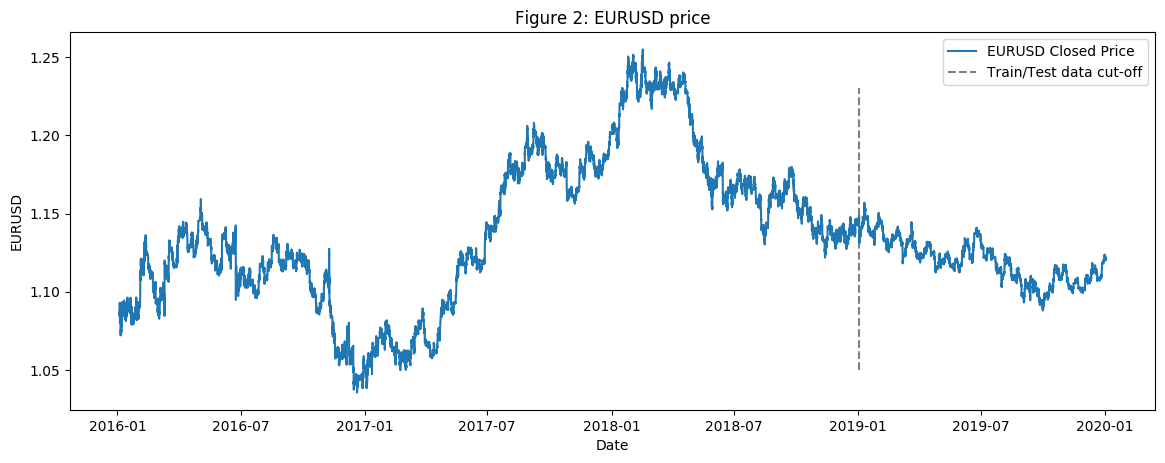

In [0]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df.index , df['close'], label='EURUSD Closed Price')
plt.vlines(datetime.date(2019,1, 2), 1.05, 1.23, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('EURUSD')
plt.title('Figure 2: EURUSD price')
plt.legend()
plt.show()

In [0]:
num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                     df.shape[0]-num_training_days))

Number of training days: 17451. Number of test days: 7480.


In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['close']-1
    
    return dataset

In [0]:
dataset_TI_df = get_technical_indicators(df)
dataset_TI_df.head(50)

,open,high,low,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
date,,,,,,,,,,,,,,,
2016-01-03 22:00:00,1.08750,1.08750,1.08668,1.08674,1645.2300,NaN,NaN,1.086740,1.086740,0.000000,NaN,NaN,NaN,1.086740,0.08674
2016-01-03 23:00:00,1.08673,1.08675,1.08456,1.08520,4719.0601,NaN,NaN,1.085940,1.085906,-0.000035,NaN,NaN,NaN,1.085585,0.08520
2016-01-04 00:00:00,1.08520,1.08580,1.08434,1.08457,4561.9702,NaN,NaN,1.085448,1.085384,-0.000064,NaN,NaN,NaN,1.084882,0.08457
2016-01-04 01:00:00,1.08456,1.08621,1.08274,1.08603,6698.0098,NaN,NaN,1.085611,1.085588,-0.000022,NaN,NaN,NaN,1.085657,0.08603
2016-01-04 02:00:00,1.08604,1.08759,1.08587,1.08719,6379.8901,NaN,NaN,1.085977,1.086023,0.000046,NaN,NaN,NaN,1.086683,0.08719
2016-01-04 03:00:00,1.08719,1.08732,1.08673,1.08714,3722.1101,NaN,NaN,1.086210,1.086295,0.000085,NaN,NaN,NaN,1.086988,0.08714
2016-01-04 04:00:00,1.08714,1.08838,1.08698,1.08793,4684.5298,1.086400,NaN,1.086516,1.086660,0.000144,NaN,NaN,NaN,1.087616,0.08793
2016-01-04 05:00:00,1.08797,1.09049,1.08742,1.08976,6456.3398,1.086831,NaN,1.087039,1.087307,0.000268,NaN,NaN,NaN,1.089046,0.08976
2016-01-04 06:00:00,1.08975,1.09027,1.08844,1.08892,5652.7300,1.087363,NaN,1.087317,1.087626,0.000308,NaN,NaN,NaN,1.088962,0.08892


In [0]:
def plot_technical_indicators(dataset, start_date, end_date):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
 
   
    dataset = dataset.loc[start_date:end_date]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for EURUSD - between {} and {}.'.format(start_date, end_date))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')

    plt.legend()
    plt.show()

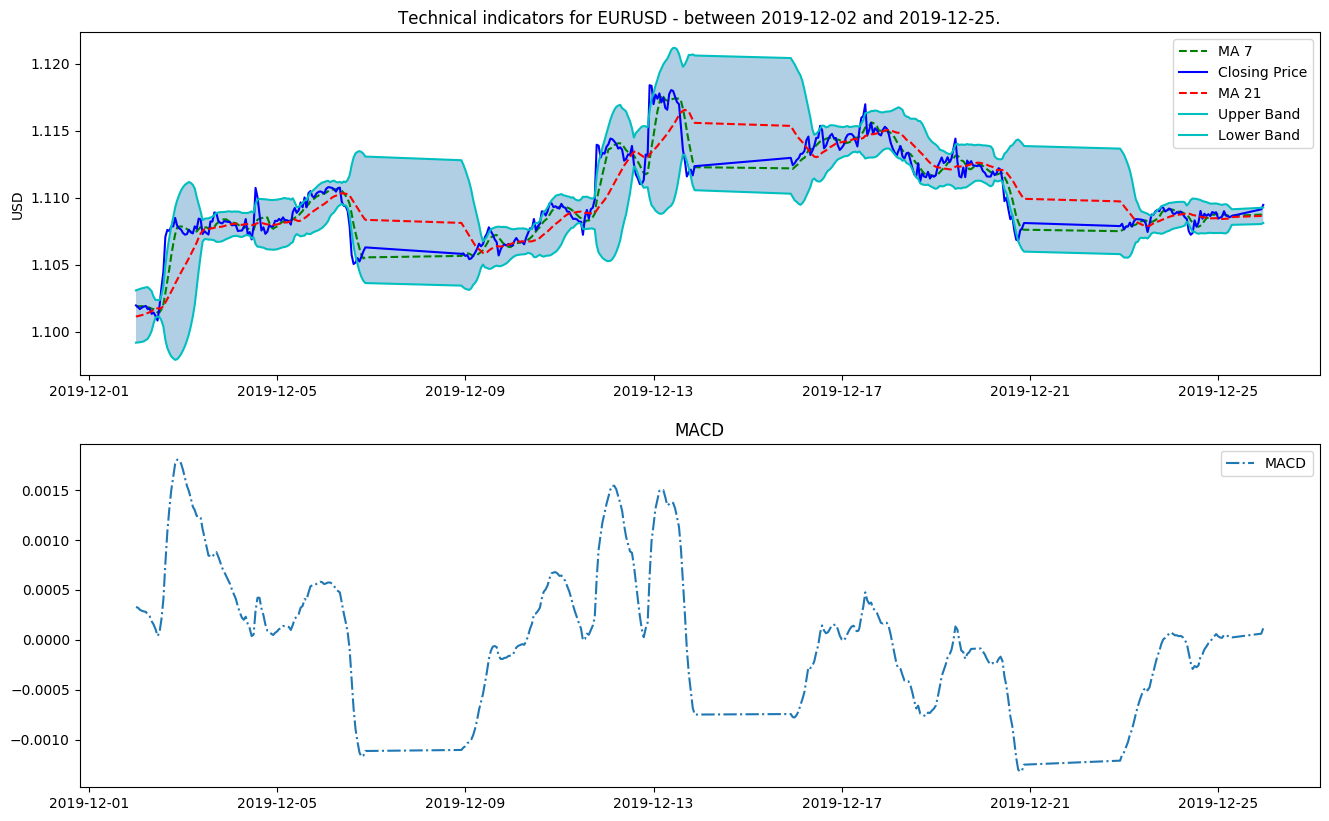

In [0]:
plot_technical_indicators(dataset_TI_df, '2019-12-02','2019-12-25')